# ABSA Case Study
You are a data scientist who has been tasked with developing a versatile ABSA model for extracting aspects, determining aspect polarity, and detecting aspect categories from textual data. The goal is to create a robust model/pipeline ensuring flexibility and accuracy across different contexts.

Aspect-Based Sentiment Analysis (ABSA) is a natural language processing (NLP) technique that involves extracting and analysing sentiment or emotion associated with specific aspects or features of a given target entity, such as a product, service, or topic.  

Data Description:
Your toolkit will include dataset comprising of 3000 customer reviews for a restaurant, all in English, enriched with human-authored annotations. These annotations contain the mentioned aspects of the target entities and the sentiment polarity of each aspect.


Tasks:

•	ABSA Model Development: Create an ABSA model that can extract aspect terms, determine aspect polarity, and identify aspect categories within a given text. Ensure that the model is generic and can be applied to different domains with ease.
•	Results Analysis: Analyze the results generated by the ABSA model. Use matplotlib/ plotly to show the overall as well category wise sentiment distribution. 
•	Actionable insights: Based on the above analysis, derive the conclusions and identify action items for the restaurant to work-upon.
•	Report: Discuss pros and cons of the approach you selected and further improvement which can be done to it given more time.


In particular, the task 1 consists of the following subtasks: 
 
Definition 1: Aspect term extraction 
For the given entity -  restaurant, identify the aspect terms present in the sentence and return a list containing all the distinct aspect terms. An aspect term names a particular aspect of the target entity(Restaurant). 
  
For example, "I liked the service and the staff, but not the food”, “The food was nothing much, but I loved the staff”. Here service, staff and food are aspects.

 Note: Multi-word aspect terms (e.g., “hard disk”) should be treated as single terms (e.g., in “The hard disk is very noisy” the only aspect term is “hard disk”). 
 
Definition 2: Aspect term polarity 
For a given set of aspect terms within a sentence, determine whether the polarity of each aspect term is positive, negative, neutral or conflict (i.e., both positive and negative). 
  
For example: 
 
“I loved their fajitas” → {fajitas: positive} 
“I hated their fajitas, but their salads were great” → {fajitas: negative, salads: positive} 
“The fajitas are their first plate” → {fajitas: neutral} 
“The fajitas were great to taste, but not to see” → {fajitas: conflict} 
 
Definition 3: Aspect category detection 
Decide a predefined set of aspect categories (e.g., price, food, service etc.) for restaurant, identify the aspect categories discussed in a given sentence. Aspect categories are typically coarser than the aspect terms of Subtask 1, and they do not necessarily occur as terms in the given sentence. 
  
For example, given the set of aspect categories {food, service, price, ambience, anecdotes/miscellaneous}: 
“The restaurant was too expensive”  → {aspect -expensive, category - price} 
“The restaurant was expensive, but the menu was great” → { aspect -expensive, category - price, aspect- menu, category - food} 

Definition 4:
Action Items: Areas which can be improved to improve the overall sentiment of the customer.
 


#### List Packages we need to Install
- xmltodict
- pandas
- nltk
- matplotlib
- plotly
- torch
- transformers
- datasets

In [1]:
# !pip install xmltodict


### Creating Essential Folder Structure

In [2]:
import os
def create_directory(dirs: list):
    for dir_path in dirs:
        os.makedirs(dir_path, exist_ok=True)


create_directory(['artifacts/dataset_NER','artifacts/dataset_Category','artifacts/models/ner/final','artifacts/models/ner/epoch','artifacts/dataset','artifacts/models/ner','artifacts/models/category','artifacts/models/sentence_inference'])       

## Loading the XML Data and Pre-processing

In [3]:
import xmltodict

# Open and read the XML file
with open('artifacts/data/Restaurants_Train_v2.xml', 'r') as f:
    xml_content = f.read()

# Convert the XML to a dictionary
xml_dict = xmltodict.parse(xml_content)



#### Let's First see how that Data Looks

In [4]:
print(xml_dict['sentences']['sentence'][0:10])

[{'@id': '3121', 'text': 'But the staff was so horrible to us.', 'aspectTerms': {'aspectTerm': {'@term': 'staff', '@polarity': 'negative', '@from': '8', '@to': '13'}}, 'aspectCategories': {'aspectCategory': {'@category': 'service', '@polarity': 'negative'}}}, {'@id': '2777', 'text': "To be completely fair, the only redeeming factor was the food, which was above average, but couldn't make up for all the other deficiencies of Teodora.", 'aspectTerms': {'aspectTerm': {'@term': 'food', '@polarity': 'positive', '@from': '57', '@to': '61'}}, 'aspectCategories': {'aspectCategory': [{'@category': 'food', '@polarity': 'positive'}, {'@category': 'anecdotes/miscellaneous', '@polarity': 'negative'}]}}, {'@id': '1634', 'text': "The food is uniformly exceptional, with a very capable kitchen which will proudly whip up whatever you feel like eating, whether it's on the menu or not.", 'aspectTerms': {'aspectTerm': [{'@term': 'food', '@polarity': 'positive', '@from': '4', '@to': '8'}, {'@term': 'kitchen

In [5]:
print(len(xml_dict['sentences']['sentence']))

3041


## First Observation what we can understand from the Data
- It has total 3041 Text and ID's
- Aspect Term: Some place it has multiple Data, some places only single or No Entries.
    - Each Term is coming with label Positive or Negative or Neutral
- Aspect Category: This also in some place Single Data or Multiple Data
    - Similar to Term, it also have each category has label Positive or Negative or Neutral(Not shown here but assuming that is the case)


## First Impression and Understanding

After reading and seeing the dataset, the first impression for the task ABSA Model Development are below:
    - For TERM's the basic impression is NER that would extract words which is Important to Resttaurant Business. 
    - For TERM we also need to Sentence Inferencing between extracted NER and Text to find Polarity i.e. Positive, Negative & Neutral. 
    - For Category we need to do Multi-Label sentence Classification for given labels: food, service, price, ambience, anecdotes/miscellaneous.
    - For Category also we have to do Sentence Inferencing between Category and Text to find Polarity i.e. Positive, Negative & Neutral. Since in Sample Data viewing we can't find Neutral therefore this is still assumption that there are three labels, will Do EDA to find it

**With above thought we have to do NER and Multi-Label Sentence Classification training at least and for Sentence Inferencing we will see if we need to train Sentence Inferencing**


**I will try to find if any NER and Multi-Label Sentence Classification models in huggingface hub is available or not which will act as a baseline**  


**Data will have to be splitted between Train and Test as there is not seperate test data was shared with the package**

## We can't use XML Data as given, so we are doing some pre-processing. We would convert data for NER, Multi-Label Sentence Classification and Sentence Inferencing

##### **get_clean_text:** This function is used for Text clean-up. Found some corner case in the text which causing exception so doing pre-prcessing on the text.

In [6]:
import re

def get_clean_text(text):
    # Step 1: Remove single or double quotes surrounding words
    cleaned_string = re.sub(r"(['\"])(\w+)\1", r"\2", text)

    # Step 2: Remove any remaining special characters except apostrophes
    cleaned_string = re.sub(r"[^A-Za-z0-9\s']", '', cleaned_string)
    return cleaned_string



##### **get_ner:** Main motive of this function is to create NER Labels in ***CoNLL*** format. It takes these Input Parameter i.e. Splited Text, Term, From & To positions of the Term in Text and NER Label which would be changed and sent back by updating the NER Label's for the Term. NER Label's are {0: Others, 1: Begin, 2: Intermediate}. The Output Parameter would be Split text & NER Label

In [7]:
def get_ner(split_text,term,from_to,ner_label):
  # split_text = text.split()
  split_term = term.split()

  next=0
  last=0
  word_range=[]
  t_word_range=[]
  index_range=[]

  for k,v in enumerate(split_text):
    word_range.append(v)
    t_word_range.append( get_clean_text(v))
    if v[0] not in ["'",'"']:
      index_range.append(next)
    else:
      index_range.append(next+1)
    # print(v[0])
    if k == 0:
      last = len(v)+1
       
    else:
      last=last+len(v)+1
       
    next = last
  t_index = 0
  try:
    t_index = index_range.index(from_to)
    # print(t_index)
  except:
     
    try:
      t_index = t_word_range.index(split_term[0] )
    except:
      for k,i in enumerate(t_word_range):
        if split_term[0] in i:
          t_index = k
       
  end = t_index + len(split_term)
  
  for k,v in enumerate(range(t_index,end)):
    if k==0:
      ner_label[v]= 1
    else:
      ner_label[v]= 2
  # print(ner_label)
  return word_range, ner_label

##### **get_dataset:** This is the main function which would be called for pre-processing the xml-data. Only Input Parameter is XML_Data and Output Parameter is a list of Dictionary,category_label: {'ambience':0, 'anecdotes/miscellaneous' : 1, 'food':2, 'price':3, 'service':4} and polarity_label: {'conflict':0,'neutral':1,'negative':2,'positive':3}

In [8]:
def get_dataset(xml_dict):
  dataset_aspect = []
  all_lb = set()
  for k,v in enumerate(xml_dict['sentences']['sentence']):
    ds = {}
    category_label = {'ambience':0, 'anecdotes/miscellaneous' : 1, 'food':2, 'price':3, 'service':4}
    # polarity_label_term = {'neutral':0,'negative':1,'positive':2} # 'conflict'
    polarity_label = {'conflict':0,'neutral':1,'negative':2,'positive':3} # 'conflict'
    # if k == 5:
    #   break
    dict_keys = v.keys()
    ds['ID'] = v['@id']
    ds['text'] = v['text']
    ds['NER_INFERENCE'] ={}
    ds['NER_INFERENCE']['term']=[]
    ds['NER_INFERENCE']['polarity']=[]
    ds['NER_INFERENCE']['polarity_label']=[]
    ds['NER_INFERENCE']['from_to']=[]
    ds['NER_INFERENCE']['text']= v['text'].split()
    ds['NER_INFERENCE']['ner_label']= [0]*len(v['text'].split())
    ds['categories']={}
    ds['categories']['category']=[]
    ds['categories']['category_label']=[]
    ds['categories']['polarity']=[]
    ds['categories']['polarity_label']=[]
    # print( v['aspectCategories'])
    # print(dict_keys)
    if 'aspectTerms' in dict_keys:
      if type(v['aspectTerms']['aspectTerm'])==dict:
        # tmp_dict={}
        ds['NER_INFERENCE']['term'].append(v['aspectTerms']['aspectTerm']['@term'])
        ds['NER_INFERENCE']['polarity'].append(v['aspectTerms']['aspectTerm']['@polarity']) #loop
        tmp =[polarity_label[v['aspectTerms']['aspectTerm']['@polarity']]  ]
        ds['NER_INFERENCE']['polarity_label'].extend(tmp ) #loop
        ds['NER_INFERENCE']['from_to'].append((int(v['aspectTerms']['aspectTerm']['@from']),int(v['aspectTerms']['aspectTerm']['@to'])))
        ds['NER_INFERENCE']['text'],ds['NER_INFERENCE']['ner_label']= get_ner(
                                                                                ds['NER_INFERENCE']['text'],
                                                                                v['aspectTerms']['aspectTerm']['@term'],
                                                                                int(v['aspectTerms']['aspectTerm']['@from']),
                                                                                  ds['NER_INFERENCE']['ner_label']
                                                                              )

      else:
        for key,value in enumerate(v['aspectTerms']['aspectTerm']):
          # tmp_dict={}
          ds['NER_INFERENCE']['term'].append(value['@term'])
          ds['NER_INFERENCE']['polarity'].append(value['@polarity']) # loop
          tmp = [polarity_label[value['@polarity']] ]
          ds['NER_INFERENCE']['polarity_label'].extend(tmp) # loop
          ds['NER_INFERENCE']['from_to'].append((int(value['@from']),int(value['@to'])))
          # try:
          ds['NER_INFERENCE']['text'],ds['NER_INFERENCE']['ner_label']= get_ner(
                                                                                ds['NER_INFERENCE']['text'],
                                                                                value['@term'],
                                                                                int(value['@from']),
                                                                                  ds['NER_INFERENCE']['ner_label']
                                                                              )
          # except Exception as e:
          #   print(e)
          #   print('Text: ',ds['text'],' Term: ',value['@term']," from: ",int(value['@from']))
          #   return "error"

    if 'aspectCategories' in dict_keys :
      # print( v['aspectCategories'])
      if type(v['aspectCategories']['aspectCategory'])==dict:
        # print( v['aspectCategories']['aspectCategory']) #['@category'] category_label
        ds['categories']['category'].append(v['aspectCategories']['aspectCategory']['@category']) #loop
        ds['categories']['polarity'].append(v['aspectCategories']['aspectCategory']['@polarity']) #loop
        tmp1 =[category_label[v['aspectCategories']['aspectCategory']['@category']] ]
        tmp2= [polarity_label[v['aspectCategories']['aspectCategory']['@polarity']]  ]
        ds['categories']['category_label'].extend(tmp1) #loop
        ds['categories']['polarity_label'].extend(tmp2) #loop
        all_lb.add(v['aspectCategories']['aspectCategory']['@category'])
      else:
        # print(v['aspectCategories']['aspectCategory'])
        for key,value in enumerate(v['aspectCategories']['aspectCategory']):
          # print(value['@category'])
          ds['categories']['category'].append(value['@category']) #loop
          ds['categories']['polarity'].append(value['@polarity']) # loop
          tmp1 = [category_label[value['@category']]  ]
          tmp2= [polarity_label[value['@polarity']] ]
          ds['categories']['category_label'].extend(tmp1) #loop
          ds['categories']['polarity_label'].extend(tmp2) # loop
          all_lb.add(value['@category'])
      # pass
    dataset_aspect.append(ds)
  return dataset_aspect,category_label , polarity_label

In [9]:
dataset_aspect,category_label , polarity_label= get_dataset(xml_dict)

##### List of Category and polarity label

In [10]:
category_label , polarity_label

({'ambience': 0,
  'anecdotes/miscellaneous': 1,
  'food': 2,
  'price': 3,
  'service': 4},
 {'conflict': 0, 'neutral': 1, 'negative': 2, 'positive': 3})

##### After Pre-processing just vewing the data

In [66]:
dataset_aspect[:10]

[{'ID': '3121',
  'text': 'But the staff was so horrible to us.',
  'NER_INFERENCE': {'term': ['staff'],
   'polarity': ['negative'],
   'polarity_label': [2],
   'from_to': [(8, 13)],
   'text': ['But', 'the', 'staff', 'was', 'so', 'horrible', 'to', 'us.'],
   'ner_label': [0, 0, 1, 0, 0, 0, 0, 0]},
  'categories': {'category': ['service'],
   'category_label': [4],
   'polarity': ['negative'],
   'polarity_label': [2]}},
 {'ID': '2777',
  'text': "To be completely fair, the only redeeming factor was the food, which was above average, but couldn't make up for all the other deficiencies of Teodora.",
  'NER_INFERENCE': {'term': ['food'],
   'polarity': ['positive'],
   'polarity_label': [3],
   'from_to': [(57, 61)],
   'text': ['To',
    'be',
    'completely',
    'fair,',
    'the',
    'only',
    'redeeming',
    'factor',
    'was',
    'the',
    'food,',
    'which',
    'was',
    'above',
    'average,',
    'but',
    "couldn't",
    'make',
    'up',
    'for',
    'all',
 

In [12]:
import json

with open("artifacts/data/process_data.jsonl", "w") as final:
    json.dump(dataset_aspect, final)

## Now Loading Dataset in Huggingface Datasets

In [13]:
from datasets import load_dataset
dataset = load_dataset("json", data_files="artifacts/data/process_data.jsonl")
dataset

/Users/nabarunbarua/miniconda3/envs/case_study/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating train split: 3041 examples [00:00, 62862.88 examples/s]


DatasetDict({
    train: Dataset({
        features: ['ID', 'text', 'NER_INFERENCE', 'categories'],
        num_rows: 3041
    })
})

##### Doing Train Test split and saving the dataset

In [14]:
dataset = dataset['train'].train_test_split(test_size=0.1,seed=199)

dataset.save_to_disk('artifacts/dataset')

Saving the dataset (1/1 shards): 100%|██████████| 305/305 [00:00<00:00, 43826.88 examples/s]


##### Incase want to load from Location

In [15]:
# from datasets import load_from_disk
# ds = load_from_disk('artifacts/dataset')
# ds

### We are creating a seperate Dataset for Category/NER/EDA from main dataset so that for Training & EDA we can use it skip NER Pre-processing

In [16]:
flat_dataset = dataset.flatten()
flat_dataset

DatasetDict({
    train: Dataset({
        features: ['ID', 'text', 'NER_INFERENCE.from_to', 'NER_INFERENCE.ner_label', 'NER_INFERENCE.polarity', 'NER_INFERENCE.polarity_label', 'NER_INFERENCE.term', 'NER_INFERENCE.text', 'categories.category', 'categories.category_label', 'categories.polarity', 'categories.polarity_label'],
        num_rows: 2736
    })
    test: Dataset({
        features: ['ID', 'text', 'NER_INFERENCE.from_to', 'NER_INFERENCE.ner_label', 'NER_INFERENCE.polarity', 'NER_INFERENCE.polarity_label', 'NER_INFERENCE.term', 'NER_INFERENCE.text', 'categories.category', 'categories.category_label', 'categories.polarity', 'categories.polarity_label'],
        num_rows: 305
    })
})

In [17]:
flat_dataset['train'][0]

{'ID': '2927',
 'text': 'The decor in this place is very diner-ish and the kind of place you expect in the East Village - not romantic, just simple, small and sparse.',
 'NER_INFERENCE.from_to': [[4, 9], [58, 63]],
 'NER_INFERENCE.ner_label': [0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'NER_INFERENCE.polarity': ['positive', 'positive'],
 'NER_INFERENCE.polarity_label': [3, 3],
 'NER_INFERENCE.term': ['decor', 'place'],
 'NER_INFERENCE.text': ['The',
  'decor',
  'in',
  'this',
  'place',
  'is',
  'very',
  'diner-ish',
  'and',
  'the',
  'kind',
  'of',
  'place',
  'you',
  'expect',
  'in',
  'the',
  'East',
  'Village',
  '-',
  'not',
  'romantic,',
  'just',
  'simple,',
  'small',
  'and',
  'sparse.'],
 'categories.category': ['ambience'],
 'categories.category_label': [0],
 'categories.polarity': ['positive'],
 'categories.polarity_label': [3]}

##### NER-EDA Dataset Preperation

polarity_label: {'conflict':0,'neutral':1,'negative':2,'positive':3}

In [18]:
NER_train = []
NER_test=[]
for data in flat_dataset['train']:
    NER_dict={}
    NER_dict['ID'] = data['ID']
    NER_dict['text']= data['text']
    NER_dict['split_text'] = data['NER_INFERENCE.text']
    NER_dict['ner_label'] = data['NER_INFERENCE.ner_label']
    NER_dict['term'] = data['NER_INFERENCE.term']
    NER_dict['polarity'] = data['NER_INFERENCE.polarity_label']
    NER_train.append(NER_dict)
    # break

for data in flat_dataset['test']:
    NER_dict={}
    NER_dict['ID'] = data['ID']
    NER_dict['text']= data['text']
    NER_dict['split_text'] = data['NER_INFERENCE.text']
    NER_dict['ner_label'] = data['NER_INFERENCE.ner_label']
    NER_dict['term'] = data['NER_INFERENCE.term']
    NER_dict['polarity'] = data['NER_INFERENCE.polarity_label']
    NER_test.append(NER_dict)
    # break

len(NER_train), len(NER_test)

(2736, 305)

In [19]:
from datasets import Dataset

train_dataset = Dataset.from_list(NER_train)
test_dataset = Dataset.from_list(NER_test)

In [20]:
from datasets import DatasetDict

NER_DATASET = DatasetDict({'train':train_dataset,'test':test_dataset})
NER_DATASET

DatasetDict({
    train: Dataset({
        features: ['ID', 'text', 'split_text', 'ner_label', 'term', 'polarity'],
        num_rows: 2736
    })
    test: Dataset({
        features: ['ID', 'text', 'split_text', 'ner_label', 'term', 'polarity'],
        num_rows: 305
    })
})

In [21]:
NER_DATASET.save_to_disk('artifacts/dataset_NER')

Saving the dataset (1/1 shards): 100%|██████████| 305/305 [00:00<00:00, 58040.14 examples/s]


In [22]:
# from datasets import load_from_disk

# NER_DATASET =  load_from_disk('artifacts/dataset_NER')

In [23]:
NER_DATASET['train'].set_format(type='pandas')
df = NER_DATASET['train'][:]
df.head()

,ID,text,split_text,ner_label,term,polarity
0,2927,The decor in this place is very diner-ish and ...,"[The, decor, in, this, place, is, very, diner-...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[decor, place]","[3, 3]"
1,2028,My friends and I experienced amazing cheese an...,"[My, friends, and, I, experienced, amazing, ch...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, ...","[cheese, menu]","[3, 3]"
2,2715,"The steak is good, the fish is good and the su...","[The, steak, is, good,, the, fish, is, good, a...","[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0]","[steak, fish, sushi]","[3, 3, 3]"
3,1580,The staff was the friendliest that have seen i...,"[The, staff, was, the, friendliest, that, have...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",[staff],[3]
4,958,"I choose to go with one of the special, the br...","[I, choose, to, go, with, one, of, the, specia...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 2, 2, 2, 2, ...","[braised lamb shank in red wine, special]","[3, 3]"


In [24]:
NER_DATASET['train'].reset_format()

In [25]:
NER_DATASET['train']

Dataset({
    features: ['ID', 'text', 'split_text', 'ner_label', 'term', 'polarity'],
    num_rows: 2736
})

##### Category-EDA Dataset Preperation

category_label: {'ambience':0, 'anecdotes/miscellaneous' : 1, 'food':2, 'price':3, 'service':4} 


polarity_label: {'conflict':0,'neutral':1,'negative':2,'positive':3}

In [26]:
category_train = []
category_test=[]
for data in flat_dataset['train']:
    category_dict={}
    category_dict['ID'] = data['ID']
    category_dict['text']= data['text']
    category_dict['category_label'] = data['categories.category_label']
    category_dict['polarity_label'] = data['categories.polarity_label']
     
    category_train.append(category_dict)
    # break

for data in flat_dataset['test']:
    category_dict={}
    category_dict['ID'] = data['ID']
    category_dict['text']= data['text']
    category_dict['category_label'] = data['categories.category_label']
    category_dict['polarity_label'] = data['categories.polarity_label']
    category_test.append(category_dict)
    # break

len(category_train), len(category_test)

(2736, 305)

In [27]:
from datasets import Dataset

train_dataset = Dataset.from_list(category_train)
test_dataset = Dataset.from_list(category_test)

In [28]:
from datasets import DatasetDict

CATEGORY_DATASET = DatasetDict({'train':train_dataset,'test':test_dataset})
CATEGORY_DATASET

DatasetDict({
    train: Dataset({
        features: ['ID', 'text', 'category_label', 'polarity_label'],
        num_rows: 2736
    })
    test: Dataset({
        features: ['ID', 'text', 'category_label', 'polarity_label'],
        num_rows: 305
    })
})

In [29]:
CATEGORY_DATASET.save_to_disk('artifacts/dataset_Category')

Saving the dataset (1/1 shards): 100%|██████████| 305/305 [00:00<00:00, 83328.73 examples/s]


In [30]:
# from datasets import load_from_disk

# CATEGORY_DATASET =  load_from_disk('artifacts/dataset_Category')

In [31]:
CATEGORY_DATASET['train'].set_format(type='pandas')
df = CATEGORY_DATASET['train'][:]
df.head()

,ID,text,category_label,polarity_label
0,2927,The decor in this place is very diner-ish and ...,[0],[3]
1,2028,My friends and I experienced amazing cheese an...,"[2, 1]","[3, 3]"
2,2715,"The steak is good, the fish is good and the su...",[2],[3]
3,1580,The staff was the friendliest that have seen i...,[4],[3]
4,958,"I choose to go with one of the special, the br...",[2],[3]


In [32]:
CATEGORY_DATASET['train'].reset_format()

In [33]:
CATEGORY_DATASET['train']

Dataset({
    features: ['ID', 'text', 'category_label', 'polarity_label'],
    num_rows: 2736
})

## All Dataset Preparation done. Now let's do EDA.


#### Let's check for Text Length

We can see Maximum Number of Words would be 69 and Minimum would be 1

In [34]:
def text_length(dataset,label):
    max_length = 0
    min_length = 99999999
    
    ds =  dataset[label]
    ds.set_format(type='pandas')
    df = ds[:]
    # min_length=min(min_length,len(df['split_text'][0]))
    for data in df['split_text']:
        max_length = max(max_length,len(data))
        min_length=min(min_length,len(data))
    
    print("Max Length:",max_length, "Min Length:",min_length)

    

In [35]:
text_length(NER_DATASET,"train")

Max Length: 69 Min Length: 1


In [36]:
text_length(NER_DATASET,"test")

Max Length: 43 Min Length: 1


#### Let's check Polarity count for TERM

In [37]:
def polarity_NER(dataset,label):
    polarity_label_id= {0:'conflict',1:'neutral',2:'negative',3:'positive'}
    ds = dataset[label]
    conflict=0
    neutral=0
    negative=0
    positive=0

    ds.set_format(type='pandas')
    df = ds[:]
    for term,polarity in zip(df['term'],df['polarity']):
        # print(term,polarity)
        for i in polarity:
            if polarity_label_id[i] == 'conflict':
                conflict += 1
            elif polarity_label_id[i] == 'neutral':
                neutral +=1
            elif polarity_label_id[i] == 'negative':
                negative +=1
            elif polarity_label_id[i] == 'positive':
                positive +=1

        
    print("Conflict: ",conflict," Neutral: ",neutral," Negative: ",negative," Positive: ",positive)

In [38]:
polarity_NER(NER_DATASET,'train')

Conflict:  83  Neutral:  561  Negative:  687  Positive:  1966


##### We can see that Conflict has 83 count only and Negative 687 & Conflict mean same only so merging Conflict and Negative

In [39]:
polarity_NER(NER_DATASET,'test')

Conflict:  8  Neutral:  72  Negative:  118  Positive:  198


##### Same we can see that Conflict has 8 count only and Negative 118 & Conflict mean same only so merging Conflict and Negative

##### merge code for conflict and negative

In [40]:
def polarity_funct(examples):
    polarity = [
                    [ 
                       2 if j==0 else j for j in i  
                    ] for i in examples['polarity']
                ]
    examples['polarity']= polarity
    return examples
    
Process_NER_Dataset = NER_DATASET.map(polarity_funct, batched=True)
Process_NER_Dataset

Map: 100%|██████████| 305/305 [00:00<00:00, 62564.81 examples/s]


DatasetDict({
    train: Dataset({
        features: ['ID', 'text', 'split_text', 'ner_label', 'term', 'polarity'],
        num_rows: 2736
    })
    test: Dataset({
        features: ['ID', 'text', 'split_text', 'ner_label', 'term', 'polarity'],
        num_rows: 305
    })
})

##### Now we can see Both train and test dataset for conflict issue is fixed

In [41]:
polarity_NER(Process_NER_Dataset,'train')

Conflict:  0  Neutral:  561  Negative:  770  Positive:  1966


In [42]:
polarity_NER(Process_NER_Dataset,'test')

Conflict:  0  Neutral:  72  Negative:  126  Positive:  198


#### Let's check Polarity count for Category


In [43]:
def polarity_Category(dataset,label):
    polarity_label_id= {0:'conflict',1:'neutral',2:'negative',3:'positive'}
    ds = dataset[label]
    conflict=0
    neutral=0
    negative=0
    positive=0

    ds.set_format(type='pandas')
    df = ds[:]
    for category,polarity in zip(df['category_label'],df['polarity_label']):
        # print(term,polarity)
        for i in polarity:
            if polarity_label_id[i] == 'conflict':
                conflict += 1
            elif polarity_label_id[i] == 'neutral':
                neutral +=1
            elif polarity_label_id[i] == 'negative':
                negative +=1
            elif polarity_label_id[i] == 'positive':
                positive +=1

        
    print("Conflict: ",conflict," Neutral: ",neutral," Negative: ",negative," Positive: ",positive)

##### Similar to NER, here in Category Trend is same for both train & test

In [44]:
polarity_Category(CATEGORY_DATASET,'train')

Conflict:  167  Neutral:  450  Negative:  746  Positive:  1985


In [45]:
polarity_Category(CATEGORY_DATASET,'test')

Conflict:  28  Neutral:  50  Negative:  93  Positive:  194


##### Now let's see if we take both category and polarity togather then how it looks

In [46]:
from pprint import pprint
def polarity_Category_wise(dataset,label):
    polarity_label_id= {0:'conflict',1:'neutral',2:'negative',3:'positive'}
    category_label_id= {0:'ambience',1: 'anecdotes/miscellaneous' , 2:'food', 3:'price', 4:'service'}  
    ds = dataset[label]
    # conflict=0
    # neutral=0
    # negative=0
    # positive=0

    calculate_category = {
                            'ambience': {'conflict':0,'neutral':0,'negative':0,'positive':0,'total_count':0},
                            'anecdotes/miscellaneous':{'conflict':0,'neutral':0,'negative':0,'positive':0,'total_count':0},
                            'food': {'conflict':0,'neutral':0,'negative':0,'positive':0,'total_count':0},
                            'price': {'conflict':0,'neutral':0,'negative':0,'positive':0,'total_count':0},
                            'service': {'conflict':0,'neutral':0,'negative':0,'positive':0,'total_count':0},
                          }

    ds.set_format(type='pandas')
    df = ds[:]
    for category,polarity in zip(df['category_label'],df['polarity_label']):
        for c,p in zip(category,polarity):
            if category_label_id[c]== 'ambience':
                calculate_category['ambience']['total_count'] +=1
                if polarity_label_id[p] == 'conflict':
                    calculate_category['ambience']['conflict'] += 1
                elif polarity_label_id[p] == 'neutral':
                    calculate_category['ambience']['neutral'] +=1
                elif polarity_label_id[p] == 'negative':
                    calculate_category['ambience']['negative'] +=1
                elif polarity_label_id[p] == 'positive':
                    calculate_category['ambience']['positive'] +=1

            elif category_label_id[c]== 'anecdotes/miscellaneous':
                calculate_category['anecdotes/miscellaneous']['total_count'] +=1
                if polarity_label_id[p] == 'conflict':
                    calculate_category['anecdotes/miscellaneous']['conflict'] += 1
                elif polarity_label_id[p] == 'neutral':
                    calculate_category['anecdotes/miscellaneous']['neutral'] +=1
                elif polarity_label_id[p] == 'negative':
                    calculate_category['anecdotes/miscellaneous']['negative'] +=1
                elif polarity_label_id[p] == 'positive':
                    calculate_category['anecdotes/miscellaneous']['positive'] +=1

            elif category_label_id[c]== 'food':
                calculate_category['food']['total_count'] +=1
                if polarity_label_id[p] == 'conflict':
                    calculate_category['food']['conflict'] += 1
                elif polarity_label_id[p] == 'neutral':
                    calculate_category['food']['neutral'] +=1
                elif polarity_label_id[p] == 'negative':
                    calculate_category['food']['negative'] +=1
                elif polarity_label_id[p] == 'positive':
                    calculate_category['food']['positive'] +=1

            elif category_label_id[c]== 'price':
                calculate_category['price']['total_count'] +=1
                if polarity_label_id[p] == 'conflict':
                    calculate_category['price']['conflict'] += 1
                elif polarity_label_id[p] == 'neutral':
                    calculate_category['price']['neutral'] +=1
                elif polarity_label_id[p] == 'negative':
                    calculate_category['price']['negative'] +=1
                elif polarity_label_id[p] == 'positive':
                    calculate_category['price']['positive'] +=1

            elif category_label_id[c]== 'service':
                calculate_category['service']['total_count'] +=1
                if polarity_label_id[p] == 'conflict':
                    calculate_category['service']['conflict'] += 1
                elif polarity_label_id[p] == 'neutral':
                    calculate_category['service']['neutral'] +=1
                elif polarity_label_id[p] == 'negative':
                    calculate_category['service']['negative'] +=1
                elif polarity_label_id[p] == 'positive':
                    calculate_category['service']['positive'] +=1

        
    # print("Conflict: ",conflict," Neutral: ",neutral," Negative: ",negative," Positive: ",positive)
    pprint(calculate_category)

##### Similar as above Conflict still in less in number compare to Negative. Therefore we would be merging conflict with negative. Another observation is price and ambience category has less count compare to others

In [47]:
polarity_Category_wise(CATEGORY_DATASET,'train')

{'ambience': {'conflict': 38,
              'negative': 90,
              'neutral': 22,
              'positive': 248,
              'total_count': 398},
 'anecdotes/miscellaneous': {'conflict': 29,
                             'negative': 182,
                             'neutral': 323,
                             'positive': 497,
                             'total_count': 1031},
 'food': {'conflict': 55,
          'negative': 181,
          'neutral': 77,
          'positive': 783,
          'total_count': 1096},
 'price': {'conflict': 15,
           'negative': 98,
           'neutral': 10,
           'positive': 164,
           'total_count': 287},
 'service': {'conflict': 30,
             'negative': 195,
             'neutral': 18,
             'positive': 293,
             'total_count': 536}}


In [48]:
polarity_Category_wise(CATEGORY_DATASET,'test')

{'ambience': {'conflict': 9,
              'negative': 8,
              'neutral': 1,
              'positive': 15,
              'total_count': 33},
 'anecdotes/miscellaneous': {'conflict': 1,
                             'negative': 17,
                             'neutral': 34,
                             'positive': 49,
                             'total_count': 101},
 'food': {'conflict': 11,
          'negative': 28,
          'neutral': 13,
          'positive': 84,
          'total_count': 136},
 'price': {'conflict': 2,
           'negative': 17,
           'neutral': 0,
           'positive': 15,
           'total_count': 34},
 'service': {'conflict': 5,
             'negative': 23,
             'neutral': 2,
             'positive': 31,
             'total_count': 61}}


In [49]:
# category_label	polarity_label
def polarity_funct_cat(examples):
    polarity = [
                    [ 
                       2 if j==0 else j for j in i  
                    ] for i in examples['polarity_label']
                ]
    examples['polarity_label']= polarity
    return examples
    
Process_Category_Dataset = CATEGORY_DATASET.map(polarity_funct_cat, batched=True)
Process_Category_Dataset

Map: 100%|██████████| 305/305 [00:00<00:00, 110662.87 examples/s]


DatasetDict({
    train: Dataset({
        features: ['ID', 'text', 'category_label', 'polarity_label'],
        num_rows: 2736
    })
    test: Dataset({
        features: ['ID', 'text', 'category_label', 'polarity_label'],
        num_rows: 305
    })
})

##### Now we can see Both train and test dataset for conflict issue is fixed

In [50]:
polarity_Category(Process_Category_Dataset,'train')

Conflict:  0  Neutral:  450  Negative:  913  Positive:  1985


In [51]:
polarity_Category(Process_Category_Dataset,'test')

Conflict:  0  Neutral:  50  Negative:  121  Positive:  194


## With this We End EDA and We check below NER Models

List of some Models in Huggingface Hub which will act as starting point for Fine-tuning
- https://huggingface.co/BerserkerMother/restaurant_ner
- https://huggingface.co/dvquys/ner-finetune-restaurant-reviews-aspects (This Model we will use as pre-train)



## We start Training Model 

### First we Start with NER

**Some import Function Declaration for NER and Model & Tokenizer Declaration**

In [52]:
from transformers import AutoTokenizer
from transformers import AutoModelForTokenClassification
from transformers import DataCollatorForTokenClassification
from torch.optim import AdamW
import evaluate
from transformers import TrainingArguments
import os
from dotenv import load_dotenv
import os
import wandb
load_dotenv()
wandb_key = os.getenv('WANDB_API_KEY')

wandb_key = os.getenv('WANDB_API_KEY')
wandb.login(key=wandb_key,relogin=True)

os.environ["WANDB_PROJECT"] = "New_Case_Study"
os.environ['WANDB_WATCH']= 'all'

label2id = { 'O':0, 'B':1, 'I':2}
id2label={0: 'O', 1: 'B', 2: 'I'}
model_checkpoint = "dvquys/ner-finetune-restaurant-reviews-aspects" #"bert-base-cased"

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForTokenClassification.from_pretrained(
                                                            model_checkpoint,
                                                            id2label=id2label,
                                                            label2id=label2id,
                                                            ignore_mismatched_sizes=True
                                                        ) #.to("mps")

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

# optimizer = AdamW(model.parameters(), lr=5e-5) #2e-5 - 5e-5

metric = evaluate.load("seqeval")

args = TrainingArguments(
                            output_dir="artifacts/models/ner/epoch",
                            logging_strategy = 'epoch',
                            # save_total_limit= 4,
                            eval_strategy="epoch",
                            save_strategy="epoch",
                            learning_rate=5e-5,
                            num_train_epochs=10,
                            weight_decay=0.01,
                            # use_mps_device=True,
                            greater_is_better=True,
                            load_best_model_at_end=True,
                            metric_for_best_model='f1',
                            warmup_steps=500,
                            run_name = "Run_New_Case_Study",
                            report_to="wandb",
                        )

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/nabarunbarua/.netrc
Some weights of BertForTokenClassification were not initialized from the model checkpoint at dvquys/ner-finetune-restaurant-reviews-aspects and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([21]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.weight: found shape torch.Size([21, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [53]:
model

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [54]:

import numpy as np


def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[id2label[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    all_metrics = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": all_metrics["overall_precision"],
        "recall": all_metrics["overall_recall"],
        "f1": all_metrics["overall_f1"],
        "accuracy": all_metrics["overall_accuracy"],
    }

In [55]:
def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            # Start of a new word!
            current_word = word_id
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            # Special token
            new_labels.append(-100)
        else:
            new_labels.append(-100)
    return new_labels

In [56]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
                                    examples["split_text"], truncation=True, is_split_into_words=True
                                )
    all_labels = examples["ner_label"]
    new_labels = []  	
    for i, labels in enumerate(all_labels):
        word_ids = tokenized_inputs.word_ids(i)
        new_labels.append(align_labels_with_tokens(labels, word_ids))

    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs

##### Tokenizing the NER Dataset

In [57]:
Process_NER_Dataset.reset_format()
tokenized_datasets = Process_NER_Dataset.map(
                                        tokenize_and_align_labels,
                                        batched=True,
                                        remove_columns=Process_NER_Dataset["train"].column_names,
                                    )

Map: 100%|██████████| 305/305 [00:00<00:00, 25044.79 examples/s]


In [58]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 2736
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 305
    })
})

##### Data Loader Declaration

In [59]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
                                tokenized_datasets["train"],
                                shuffle=True,
                                collate_fn=data_collator,
                                batch_size=8,
                            )
eval_dataloader = DataLoader(
                                tokenized_datasets["test"], 
                                collate_fn=data_collator, 
                                batch_size=8
                            )

##### Trainer API Execution

In [60]:
from transformers import Trainer
from transformers import EarlyStoppingCallback

erly_stp_clb = EarlyStoppingCallback(early_stopping_patience=3)
trainer = Trainer(
                    model=model,
                    args=args,
                    train_dataset=tokenized_datasets["train"],
                    eval_dataset=tokenized_datasets["test"],
                    data_collator=data_collator,
                    compute_metrics=compute_metrics,
                    tokenizer=tokenizer,
                    callbacks=[erly_stp_clb],
                )
trainer.train()

wandb: Currently logged in as: nabarunbarua. Use `wandb login --relogin` to force relogin
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


 10%|█         | 342/3420 [00:55<06:17,  8.16it/s]

{'loss': 0.233, 'grad_norm': 1.6491121053695679, 'learning_rate': 3.4200000000000005e-05, 'epoch': 1.0}


                                                  
 10%|█         | 342/3420 [00:57<06:17,  8.16it/s]

{'eval_loss': 0.08109235018491745, 'eval_precision': 0.82, 'eval_recall': 0.8282828282828283, 'eval_f1': 0.8241206030150754, 'eval_accuracy': 0.9690745986779982, 'eval_runtime': 2.3383, 'eval_samples_per_second': 130.436, 'eval_steps_per_second': 16.679, 'epoch': 1.0}


 20%|██        | 684/3420 [01:44<05:51,  7.78it/s]  

{'loss': 0.0846, 'grad_norm': 1.3393640518188477, 'learning_rate': 4.684931506849316e-05, 'epoch': 2.0}


                                                  
 20%|██        | 684/3420 [01:46<05:51,  7.78it/s]

{'eval_loss': 0.07761044800281525, 'eval_precision': 0.8443877551020408, 'eval_recall': 0.8358585858585859, 'eval_f1': 0.8401015228426396, 'eval_accuracy': 0.9716713881019831, 'eval_runtime': 1.3758, 'eval_samples_per_second': 221.694, 'eval_steps_per_second': 28.348, 'epoch': 2.0}


 30%|███       | 1026/3420 [02:32<04:52,  8.18it/s]

{'loss': 0.041, 'grad_norm': 3.3571488857269287, 'learning_rate': 4.099315068493151e-05, 'epoch': 3.0}


                                                   
 30%|███       | 1026/3420 [02:34<04:52,  8.18it/s]

{'eval_loss': 0.12126798927783966, 'eval_precision': 0.8193069306930693, 'eval_recall': 0.8358585858585859, 'eval_f1': 0.8275, 'eval_accuracy': 0.9657695939565628, 'eval_runtime': 1.4502, 'eval_samples_per_second': 210.317, 'eval_steps_per_second': 26.893, 'epoch': 3.0}


 40%|████      | 1368/3420 [03:19<04:09,  8.22it/s]

{'loss': 0.0198, 'grad_norm': 0.12172938138246536, 'learning_rate': 3.5136986301369865e-05, 'epoch': 4.0}


                                                   
 40%|████      | 1368/3420 [03:21<04:09,  8.22it/s]

{'eval_loss': 0.10609238594770432, 'eval_precision': 0.8553299492385786, 'eval_recall': 0.851010101010101, 'eval_f1': 0.8531645569620253, 'eval_accuracy': 0.972851746931067, 'eval_runtime': 1.866, 'eval_samples_per_second': 163.448, 'eval_steps_per_second': 20.9, 'epoch': 4.0}


 50%|█████     | 1710/3420 [04:09<03:27,  8.25it/s]

{'loss': 0.0117, 'grad_norm': 0.01236257515847683, 'learning_rate': 2.9280821917808222e-05, 'epoch': 5.0}


                                                   
 50%|█████     | 1710/3420 [04:11<03:27,  8.25it/s]

{'eval_loss': 0.11832107603549957, 'eval_precision': 0.8564231738035264, 'eval_recall': 0.8585858585858586, 'eval_f1': 0.8575031525851198, 'eval_accuracy': 0.9716713881019831, 'eval_runtime': 1.478, 'eval_samples_per_second': 206.36, 'eval_steps_per_second': 26.387, 'epoch': 5.0}


 60%|██████    | 2052/3420 [05:03<03:28,  6.56it/s]

{'loss': 0.0047, 'grad_norm': 0.013969868421554565, 'learning_rate': 2.342465753424658e-05, 'epoch': 6.0}


                                                   
 60%|██████    | 2052/3420 [05:05<03:28,  6.56it/s]

{'eval_loss': 0.1530652791261673, 'eval_precision': 0.8459657701711492, 'eval_recall': 0.8737373737373737, 'eval_f1': 0.8596273291925466, 'eval_accuracy': 0.9721435316336167, 'eval_runtime': 1.6823, 'eval_samples_per_second': 181.299, 'eval_steps_per_second': 23.183, 'epoch': 6.0}


 70%|███████   | 2394/3420 [05:59<02:38,  6.48it/s]

{'loss': 0.0026, 'grad_norm': 0.00490376353263855, 'learning_rate': 1.7568493150684932e-05, 'epoch': 7.0}


                                                   
 70%|███████   | 2394/3420 [06:01<02:38,  6.48it/s]

{'eval_loss': 0.14916399121284485, 'eval_precision': 0.8421052631578947, 'eval_recall': 0.8888888888888888, 'eval_f1': 0.8648648648648649, 'eval_accuracy': 0.974268177525968, 'eval_runtime': 1.7927, 'eval_samples_per_second': 170.13, 'eval_steps_per_second': 21.754, 'epoch': 7.0}


 80%|████████  | 2736/3420 [06:56<01:51,  6.13it/s]

{'loss': 0.0014, 'grad_norm': 0.0006949953967705369, 'learning_rate': 1.171232876712329e-05, 'epoch': 8.0}


                                                   
 80%|████████  | 2736/3420 [06:58<01:51,  6.13it/s]

{'eval_loss': 0.1660691648721695, 'eval_precision': 0.8632911392405064, 'eval_recall': 0.8611111111111112, 'eval_f1': 0.8621997471554994, 'eval_accuracy': 0.9733238904627006, 'eval_runtime': 1.6023, 'eval_samples_per_second': 190.356, 'eval_steps_per_second': 24.341, 'epoch': 8.0}


 90%|█████████ | 3078/3420 [07:50<00:47,  7.17it/s]

{'loss': 0.0004, 'grad_norm': 0.0006252896273508668, 'learning_rate': 5.856164383561645e-06, 'epoch': 9.0}


                                                   
 90%|█████████ | 3078/3420 [07:52<00:47,  7.17it/s]

{'eval_loss': 0.1714296191930771, 'eval_precision': 0.85785536159601, 'eval_recall': 0.8686868686868687, 'eval_f1': 0.863237139272271, 'eval_accuracy': 0.9737960339943342, 'eval_runtime': 1.6465, 'eval_samples_per_second': 185.246, 'eval_steps_per_second': 23.687, 'epoch': 9.0}


100%|██████████| 3420/3420 [08:44<00:00,  6.79it/s]

{'loss': 0.0004, 'grad_norm': 0.0008323463844135404, 'learning_rate': 0.0, 'epoch': 10.0}


                                                   
100%|██████████| 3420/3420 [08:46<00:00,  6.79it/s]

{'eval_loss': 0.17354516685009003, 'eval_precision': 0.8622448979591837, 'eval_recall': 0.8535353535353535, 'eval_f1': 0.8578680203045684, 'eval_accuracy': 0.9737960339943342, 'eval_runtime': 1.3502, 'eval_samples_per_second': 225.895, 'eval_steps_per_second': 28.885, 'epoch': 10.0}


100%|██████████| 3420/3420 [08:48<00:00,  6.47it/s]

{'train_runtime': 529.5847, 'train_samples_per_second': 51.663, 'train_steps_per_second': 6.458, 'train_loss': 0.03995770753214234, 'epoch': 10.0}


TrainOutput(global_step=3420, training_loss=0.03995770753214234, metrics={'train_runtime': 529.5847, 'train_samples_per_second': 51.663, 'train_steps_per_second': 6.458, 'total_flos': 500281660317024.0, 'train_loss': 0.03995770753214234, 'epoch': 10.0})

In [65]:
from pprint import pprint
pprint(trainer.predict(test_dataset=tokenized_datasets["test"]))

100%|██████████| 39/39 [00:01<00:00, 27.70it/s]

PredictionOutput(predictions=array([[[   7.2206593,   -3.5931456,   -4.9030175],
        [   7.791653 ,   -3.5946884,   -5.201939 ],
        [  -3.8876724,    6.6961775,   -2.2147636],
        ...,
        [-100.       , -100.       , -100.       ],
        [-100.       , -100.       , -100.       ],
        [-100.       , -100.       , -100.       ]],

       [[   7.0171757,   -3.5815012,   -4.868872 ],
        [   7.4655833,   -3.324768 ,   -4.900096 ],
        [   7.9891524,   -4.6421976,   -4.4281535],
        ...,
        [-100.       , -100.       , -100.       ],
        [-100.       , -100.       , -100.       ],
        [-100.       , -100.       , -100.       ]],

       [[   7.150614 ,   -3.3872225,   -5.098986 ],
        [   8.045873 ,   -4.481873 ,   -4.877212 ],
        [   8.067356 ,   -4.5971055,   -4.71216  ],
        ...,
        [-100.       , -100.       , -100.       ],
        [-100.       , -100.       , -100.       ],
        [-100.       , -100.       , -100.  

## Saving the Best Model i.e. Epoch 7 which has the highest F1 Score.
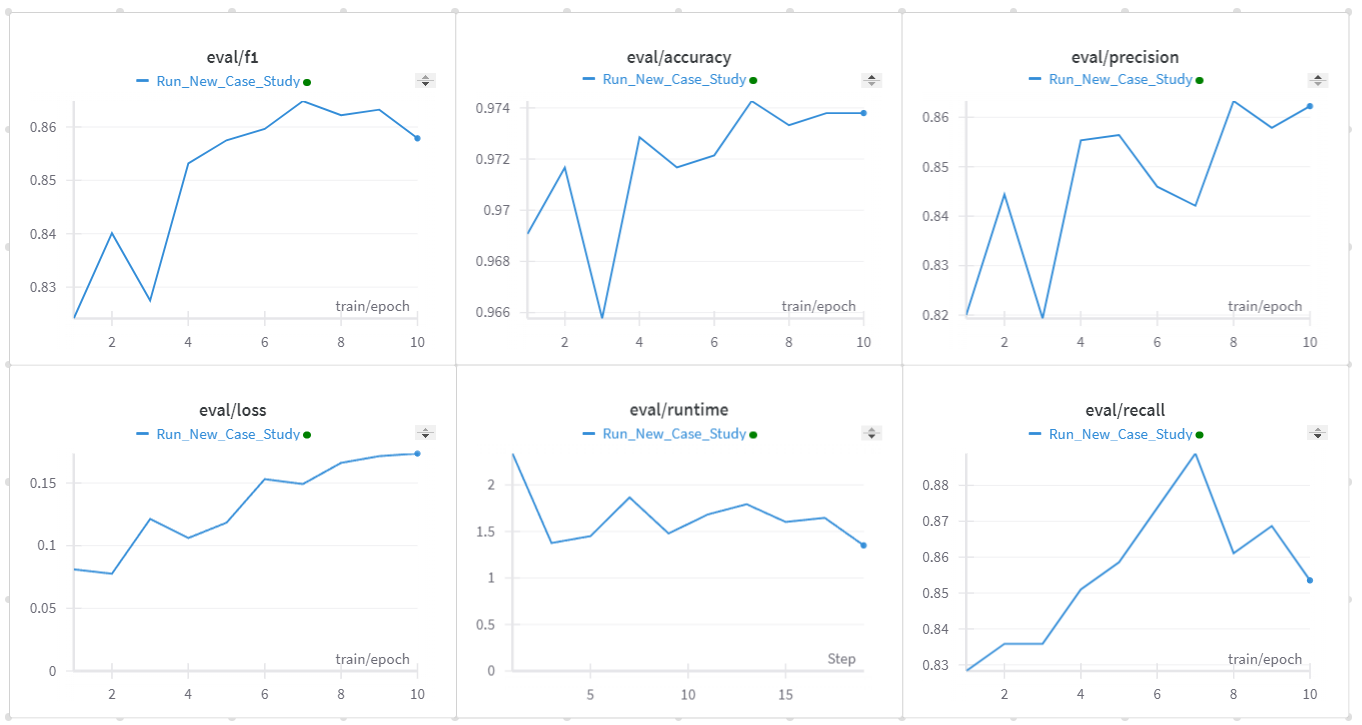

## Training Loss
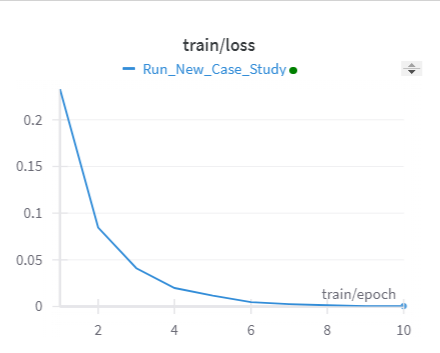

In [64]:
# trainer.model.save_pretrained('artifacts/models/ner/final')
tokenizer.save_pretrained('artifacts/models/ner/final')
trainer.save_model('artifacts/models/ner/final')

### From the above Graph we can see that at Epoch 7 we got the Highest F1 Score. I selcted F1 Score as my Metric because I wanted the balance trade-off between the precision and recall.



## Next We do Multi-Label Classification. The Input Text would be Classify into multiple label i.e. {'ambience': 0,'anecdotes/miscellaneous': 1,'food': 2, 'price': 3, 'service': 4}

In [ ]:
from transformers import AutoTokenizer
from transformers import AutoModelForTokenClassification
# from transformers import DataCollatorForTokenClassification
from torch.optim import AdamW
import evaluate
from transformers import TrainingArguments
import os
from dotenv import load_dotenv
import os
import wandb
from transformers import DataCollatorWithPadding



load_dotenv()
wandb_key = os.getenv('WANDB_API_KEY')

wandb_key = os.getenv('WANDB_API_KEY')
wandb.login(key=wandb_key,relogin=True)

os.environ["WANDB_PROJECT"] = "New_Case_Study"
os.environ['WANDB_WATCH']= 'all'

label2id = { 'O':0, 'B':1, 'I':2}
id2label={0: 'O', 1: 'B', 2: 'I'}
model_checkpoint = "dvquys/ner-finetune-restaurant-reviews-aspects" #"bert-base-cased"

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForTokenClassification.from_pretrained(
                                                            model_checkpoint,
                                                            id2label=id2label,
                                                            label2id=label2id,
                                                            ignore_mismatched_sizes=True
                                                        ) #.to("mps")

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# optimizer = AdamW(model.parameters(), lr=5e-5) #2e-5 - 5e-5

metric = evaluate.load("seqeval")

args = TrainingArguments(
                            output_dir="artifacts/models/ner/epoch",
                            logging_strategy = 'epoch',
                            # save_total_limit= 4,
                            eval_strategy="epoch",
                            save_strategy="epoch",
                            learning_rate=5e-5,
                            num_train_epochs=10,
                            weight_decay=0.01,
                            # use_mps_device=True,
                            greater_is_better=True,
                            load_best_model_at_end=True,
                            metric_for_best_model='f1',
                            warmup_steps=500,
                            run_name = "Run_New_Case_Study",
                            report_to="wandb",
                        )

In [ ]:
# # flat_dataset['train'][:1]

# NER Dataset NER Label and SPlit NER TEXT
# Then for EDA dataset example Term and polarity

In [ ]:

# from transformers import get_scheduler

# num_train_epochs = 10
# num_update_steps_per_epoch = len(train_dataloader)
# num_training_steps = num_train_epochs * num_update_steps_per_epoch

# lr_scheduler = get_scheduler(
#                                 "linear",
#                                 optimizer=optimizer,
#                                 num_warmup_steps=500,
#                                 num_training_steps=num_training_steps,
#                             )

# def postprocess(predictions, labels):
#     predictions = predictions.detach().cpu().clone().numpy()
#     labels = labels.detach().cpu().clone().numpy()

#     # Remove ignored index (special tokens) and convert to labels
#     true_labels = [[id2label[l] for l in label if l != -100] for label in labels]
#     true_predictions = [
#         [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
#         for prediction, label in zip(predictions, labels)
#     ]
#     return true_labels, true_predictions



##### Training Loop

In [ ]:
# from tqdm.auto import tqdm
# import torch

# progress_bar = tqdm(range(num_training_steps))

# for epoch in range(num_train_epochs):
#     # Training
#     model.train()
#     for batch in train_dataloader:
#         batch1 = {k:v.to("mps") for k,v in batch.items()}
#         outputs = model(**batch1)
#         loss = outputs.loss
#         loss.backward()

#         optimizer.step()
#         lr_scheduler.step()
#         optimizer.zero_grad()
#         progress_bar.update(1)

#     # Evaluation
#     model.eval()
#     for batch in eval_dataloader:
#         with torch.no_grad():
#             outputs = model(**batch)

#         predictions = outputs.logits.argmax(dim=-1)
#         labels = batch["labels"]

#         # Necessary to pad predictions and labels for being gathered
#         predictions = accelerator.pad_across_processes(predictions, dim=1, pad_index=-100)
#         labels = accelerator.pad_across_processes(labels, dim=1, pad_index=-100)

#         predictions_gathered = accelerator.gather(predictions)
#         labels_gathered = accelerator.gather(labels)

#         true_predictions, true_labels = postprocess(predictions_gathered, labels_gathered)
#         metric.add_batch(predictions=true_predictions, references=true_labels)

#     results = metric.compute()
#     print(
#         f"epoch {epoch}:",
#         {
#             key: results[f"overall_{key}"]
#             for key in ["precision", "recall", "f1", "accuracy"]
#         },
#     )

     

In [155]:
# polarity_label = {'neutral':0,'negative':1,'positive':2}
# test = []
# test1 = ['neutral','neutral']
# tmp = [polarity_label[i] for i in test1]
# test.extend(tmp)
# test

[0, 0]

In [46]:
# text = """Don't go alone---even two people isn't 'enough' for the whole experience, with pickles and a selection of meats and seafoods."""
# from nltk.tokenize import TweetTokenizer
# tokenizer = TweetTokenizer()

# tokenizer.tokenize(text)


In [47]:
# text = "Don't go alone---even two people isn't enough for the whole experience, with pickles and a selection of meats and seafoods."
# term="selection of meats and seafoods"
# from_to =(91,122)

# split_text = text.split()
# ner_label = [0]*len(split_text)
# # print(split_text)
# def get_ner(split_text,term,from_to,ner_label):
#   # split_text = text.split()
#   split_term = term.split()

#   next=0
#   last=0
#   word_range=[]
#   index_range=[]
#   for k,v in enumerate(split_text):
#     word_range.append(v)
#     index_range.append(next)
#     if k == 0:
#       last = len(v)+1
#     else:
#       last=last+len(v)+1
#     next = last
#   t_index = index_range.index(from_to[0])
#   end = t_index + len(split_term)
#   for k,v in enumerate(range(t_index,end)):
#     if k==0:
#       ner_label[v]= 1
#     else:
#       ner_label[v]= 2
#   # print(ner_label)
#   return word_range, ner_label
#   # print(split_text)
# word_range, ner_label=get_ner(split_text,term,from_to,ner_label)

# word_range, ner_label